<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Load-train-data" data-toc-modified-id="Load-train-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load train data</a></span></li><li><span><a href="#Load-test-data" data-toc-modified-id="Load-test-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load test data</a></span></li><li><span><a href="#Test-statistics" data-toc-modified-id="Test-statistics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test statistics</a></span></li><li><span><a href="#Train-statistics" data-toc-modified-id="Train-statistics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train statistics</a></span></li><li><span><a href="#Distribution-of-outcome-vs-length-of-history" data-toc-modified-id="Distribution-of-outcome-vs-length-of-history-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Distribution of outcome vs length of history</a></span></li><li><span><a href="#Serial-correlation-of-out-/under-performance" data-toc-modified-id="Serial-correlation-of-out-/under-performance-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Serial correlation of out-/under-performance</a></span></li><li><span><a href="#Filter-with-3Y-history-at-least" data-toc-modified-id="Filter-with-3Y-history-at-least-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Filter with 3Y history at least</a></span></li><li><span><a href="#Target-Mean-Encoding" data-toc-modified-id="Target-Mean-Encoding-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Target Mean Encoding</a></span></li><li><span><a href="#Feature-Enginneering" data-toc-modified-id="Feature-Enginneering-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Feature Enginneering</a></span></li><li><span><a href="#Transformation-pipeline" data-toc-modified-id="Transformation-pipeline-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Transformation pipeline</a></span></li><li><span><a href="#Train/test-split" data-toc-modified-id="Train/test-split-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Train/test split</a></span></li><li><span><a href="#Grid-Search" data-toc-modified-id="Grid-Search-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Grid Search</a></span></li><li><span><a href="#Shap" data-toc-modified-id="Shap-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Shap</a></span></li></ul></div>

# Summary

- Data is reported on Fridays, with a single report per Company (if available) per given day
- Data is more or less evenly distributed for test (Jan 2016 ÷ Sep 2019) and train (Aug 2004 ÷ Dec 2015)  
- Reporting periods for a given Company  may span from 7 days (consistent weekly reporting) to any multiple of 7 (gaps from a week to a year+)
- A gap doesn't guarantee there was no reporting in the period (a 9m gap --> report of an insider trading within 6m --> no current or previous report for a shorter period)
- Number of reports per Company id spans from 1 to 195 in test and to 595 in train
- 9695 stocks in train and 4966 in test
- 24% of Companies in test don't have history in train
- 112 Companies in test are single datapoint, with 59 out of them not having history in train
- There are some interesting artefacts in the data like longer reporting periods seem to positively correlate to better outcomes and other, that need to be explained and incorporated into modeling

# Load train data

1. Load train features and targets
2. Join targets to features for EDA
2. Convert `float64` to `float32` to save memory footprint and increase performance
3. Rename `tradingitemid` to `idx` and `g__12m_binary` to `target`
5. Check we did not loose any data

In [1]:
import pandas as pd
import numpy as np
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import log_loss
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from time import time
from datetime import timedelta
from itertools import combinations as comb
from collections import Counter
pd.options.display.max_rows=500


train_target = pd.read_pickle("./data/train_outcomes.pkl")
train_target.rename(mapper={"g__12m_binary": "target"}, axis=1, inplace=True)
train_features = pd.read_pickle("./data/train_features.pkl")
train = train_features.join(train_target, on=["date", "tradingitemid"])
floats = train.select_dtypes(include="float64").columns
train[floats] = train[floats].astype("float32")
train.reset_index(inplace=True)
train.rename(mapper={"tradingitemid": "idx"}, axis=1, inplace=True)
assert len(train_features) == len(train)
# train.to_pickle("./train.pkl")

# Load test data

1. Load test features
2. Convert `float64` to `float32` for performance
3. Reset index
4. Rename `tradingitemid` to `idx` for convinience

In [2]:
submit = pd.read_pickle("./data/test_features.pkl")
submit[floats] = submit[floats].astype("float32")
submit.reset_index(inplace=True)
submit.rename(mapper={"tradingitemid": "idx"}, axis=1, inplace=True)

# Test statistics

In [3]:
submit.sort_values(["idx", "date",])[
    ["idx", "date","f__buytransactions_1m",
    "f__buytransactions_3m",
    "f__buytransactions_6m",
    "f__buytransactions_12m"]
].head()

,idx,date,f__buytransactions_1m,f__buytransactions_3m,f__buytransactions_6m,f__buytransactions_12m
0,2585893,2016-01-01,1.0,1.0,1.0,13.0
3290,2585893,2016-01-08,11.0,11.0,11.0,15.0
6543,2585893,2016-01-15,10.0,11.0,11.0,15.0
9752,2585893,2016-01-22,10.0,11.0,11.0,15.0
12943,2585893,2016-01-29,12.0,13.0,13.0,17.0


In [4]:
submit.columns

Index(['date', 'idx', 'f__buytransactions_1m', 'f__selltransactions_1m',
       'f__buyshares_1m', 'f__sellshares_1m', 'f__buysharespctsharesout_1m',
       'f__sellsharespctsharesout_1m', 'f__uniquebuyers_1m',
       'f__uniquesellers_1m', 'f__buytransactions_3m',
       'f__selltransactions_3m', 'f__buyshares_3m', 'f__sellshares_3m',
       'f__buysharespctsharesout_3m', 'f__sellsharespctsharesout_3m',
       'f__uniquebuyers_3m', 'f__uniquesellers_3m', 'f__buytransactions_6m',
       'f__selltransactions_6m', 'f__buyshares_6m', 'f__sellshares_6m',
       'f__buysharespctsharesout_6m', 'f__sellsharespctsharesout_6m',
       'f__uniquebuyers_6m', 'f__uniquesellers_6m', 'f__buytransactions_12m',
       'f__selltransactions_12m', 'f__buyshares_12m', 'f__sellshares_12m',
       'f__buysharespctsharesout_12m', 'f__sellsharespctsharesout_12m',
       'f__uniquebuyers_12m', 'f__uniquesellers_12m'],
      dtype='object')

Test time span:

In [5]:
submit["date"].min(), submit["date"].max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2019-09-20 00:00:00'))

Number of unique stocks in test dataset:

In [6]:
submit["idx"].nunique()

4966

The data appears to be more or less evenly distributed along years with some peculiar monthly patterns for start of quarters:

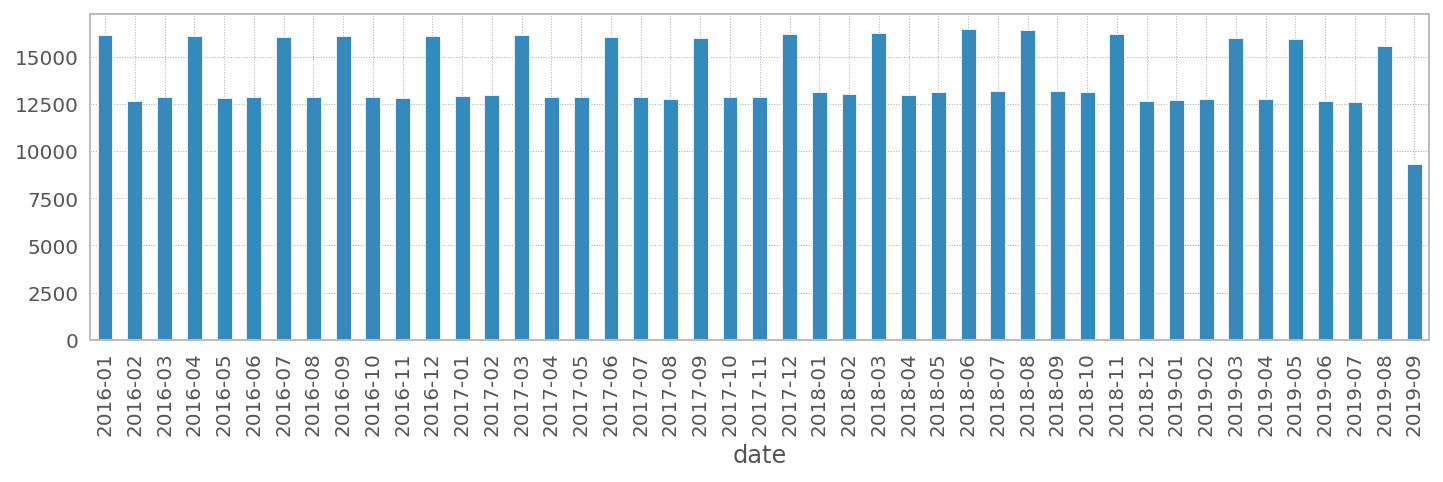

In [7]:
x = submit["date"].dt.strftime("%Y-%m")
x.groupby(x).agg(len).plot(kind="bar", figsize=(12, 3));

The reporting periods seem to be multiples of 7, 7 being by far the most common, then other multiples of 7 in the order of decreasing frequncy:

In [8]:
x = submit[["idx", "date"]].groupby("idx")["date"].transform(
    lambda x: x.diff()
).dt.days

c = Counter(x).most_common(10)
c

[(7.0, 615946),
 (14.0, 2824),
 (21.0, 1117),
 (28.0, 686),
 (35.0, 429),
 (42.0, 291),
 (49.0, 223),
 (56.0, 163),
 (63.0, 139),
 (70.0, 139)]

And the reporting seem to happen on Fridays:

In [9]:
submit["date"].dt.day_name().unique()

array(['Friday'], dtype=object)

Distribution of number of datapoints in test sample available per unique stock id:

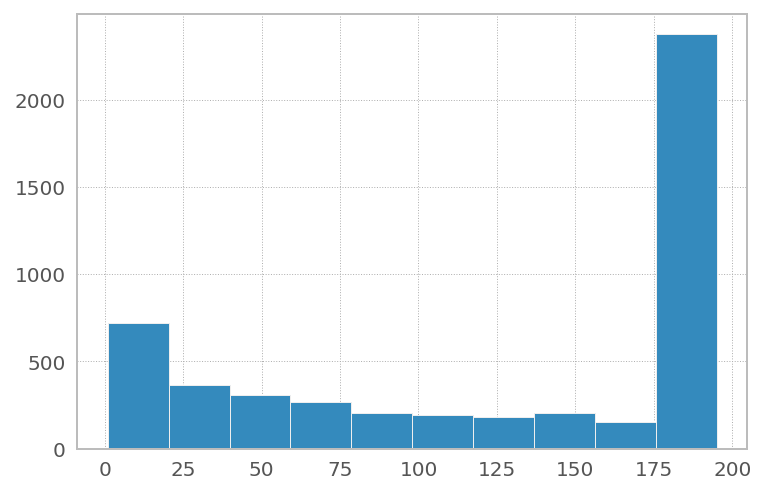

In [10]:
x = submit.groupby("idx")["date"].agg(len)
assert x.sum() == len(submit)
x.hist();

In [11]:
x.mean()

126.44140153040676

Distribution of reporting periods per Company:

In [12]:
Counter(x).most_common(10)

[(195, 2159),
 (1, 112),
 (2, 75),
 (3, 57),
 (4, 44),
 (5, 44),
 (9, 40),
 (21, 34),
 (8, 34),
 (6, 32)]

Can we enrich data for prediction with history? Let's check number of stocks in test with predecessors in train (overlap with train per stock id):

In [13]:
x = len(set(submit["idx"]) & set(train["idx"]))
x

3791

Share of stocks in test that have predecessors in train:

In [14]:
x / submit["idx"].nunique()

0.7633910592025775

Let's see how length of available data for a stock prediction may change if we add data from train:

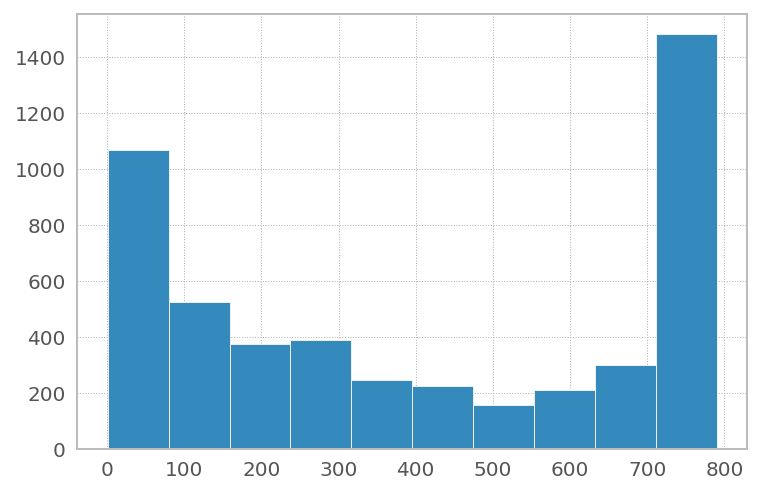

In [15]:
idxs = submit["idx"].unique()
x = (
    submit[["idx", "date"]]
    .append(train[["idx", "date"]][train["idx"].isin(idxs)])
    .groupby("idx")["date"]
    .agg(len)
)
x.hist();

Number of datapoints without history decreased from 112 to 59:

In [16]:
Counter(x.values).most_common(10)

[(790, 1095),
 (1, 59),
 (2, 47),
 (3, 35),
 (4, 27),
 (9, 26),
 (789, 22),
 (5, 21),
 (14, 21),
 (21, 21)]

Length of data available (including the datapoint to be predicted) increased 3x+:

In [17]:
x.mean()

407.29420056383407

In [18]:
# idxs = submit["idx"].unique()
# test = pd.DataFrame()
# for idx in idxs:
#     test = test.append(submit[submit["idx"] == idx]).append(train[train["idx"] == idx])

In [19]:
# (test.groupby("idx")["date"].agg(len) / submit.groupby("idx")["date"].agg(len)).mean()

In [20]:
# test.groupby("idx")["date"].agg(len).hist();

# Train statistics

Total num of datapoints:

In [21]:
len(train)

2106808

In [22]:
train["date"].min(), train["date"].max()

(Timestamp('2004-08-06 00:00:00'), Timestamp('2015-12-25 00:00:00'))

Num of unique stocks:

In [23]:
train["idx"].nunique()

9695

Train data more or less evenly distributed along years with ±20% variance in data volume:

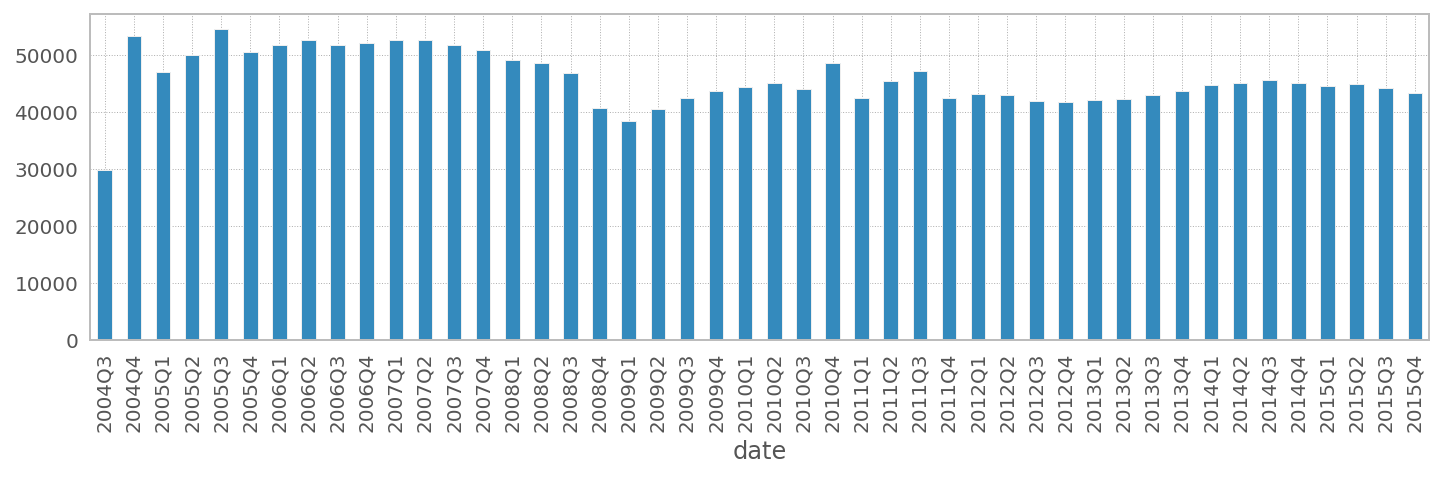

In [24]:
x = train["date"].dt.to_period("Q")
x.groupby(x).agg(len).plot(kind="bar", figsize=(12, 3));

A similar pattern, already observed in test data, is observed in train data with 7 timespan between reports being most common:

In [25]:
x = train[["idx", "date"]].groupby("idx")["date"].transform(
    lambda x: x.diff()
).dt.days

c = Counter(x).most_common(10)
c

[(7.0, 2070367),
 (14.0, 10527),
 (21.0, 4173),
 (28.0, 2374),
 (35.0, 1531),
 (42.0, 1060),
 (49.0, 793),
 (56.0, 627),
 (63.0, 503),
 (70.0, 368)]

Available history datapoints for a particular stock in train:

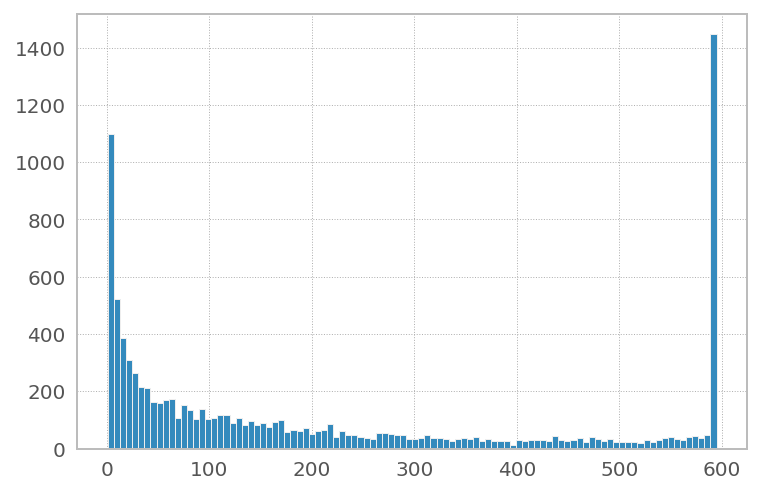

In [26]:
x = train.groupby("idx")["date"].agg(len)
x.hist(bins=100);

%%latex
\newpage

10 most common week lengths of transaction history for a particular stock: 

In [27]:
Counter(x).most_common(10)

[(595, 1364),
 (1, 320),
 (2, 228),
 (3, 184),
 (4, 133),
 (5, 120),
 (8, 119),
 (6, 114),
 (7, 99),
 (15, 85)]

In [28]:
cnt = (
    train.groupby("idx", as_index=False)["date"]
    .agg(len)
    .rename(mapper={"date": "cnt"}, axis=1)
)
train_cnt = train.merge(cnt, how="left")
assert len(train_cnt) == len(train_features)

Targets on a particular day appear balanced:

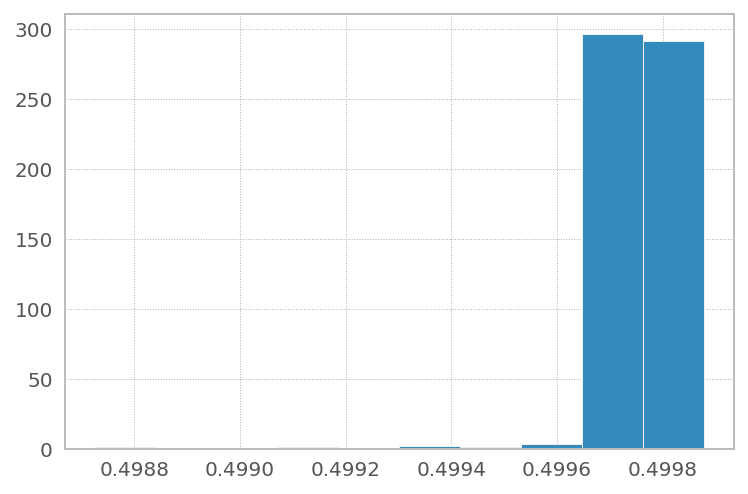

In [29]:
train.groupby("date")["target"].agg("mean").hist();

Number of available stock data on a particular date:

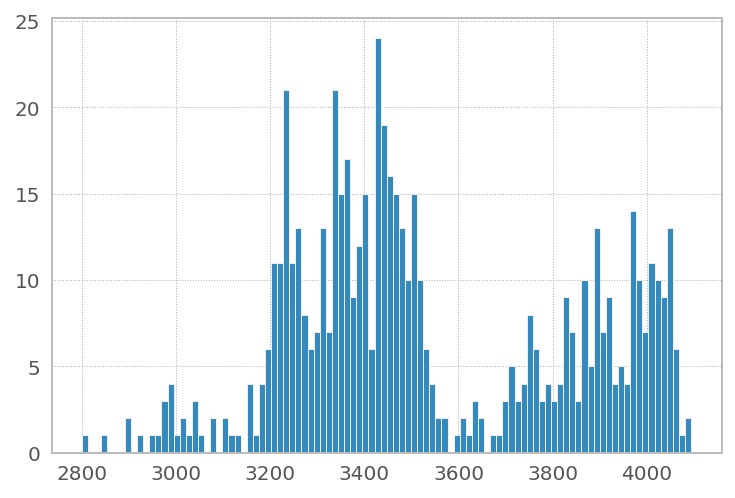

In [30]:
train.groupby("date")["idx"].agg(len).hist(bins=100);

On a single day for a given company we have exactly a single report of summary stats:

In [31]:
x = train.groupby(["date", "idx"])["target"].agg(len)
num, count = np.unique(x, return_counts=True)
assert count == len(train)
num, count

(array([1]), array([2106808]))

# Distribution of outcome vs length of history

In [32]:
train["count"] = train.groupby("idx")["date"].transform("count")
train[train["count"]==1]["target"].mean()

0.1375

In [33]:
train = train.sort_values(["idx","date"],ascending=True)

train["cnt"] = (
    train
    .groupby("idx")["date"]
    .expanding()
    .count()
    .values
)

In [34]:
cnts = train["cnt"].unique()
target = []
for cnt in cnts:
    target.append(train[train["cnt"]==cnt]["target"].mean())

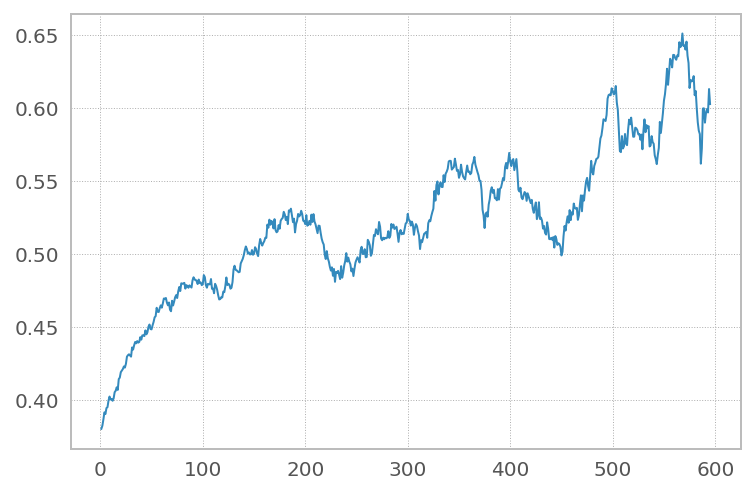

In [35]:
plt.plot(cnts,target);

# Serial correlation of out-/under-performance

Areas of under-/over-performance visually look clustered:

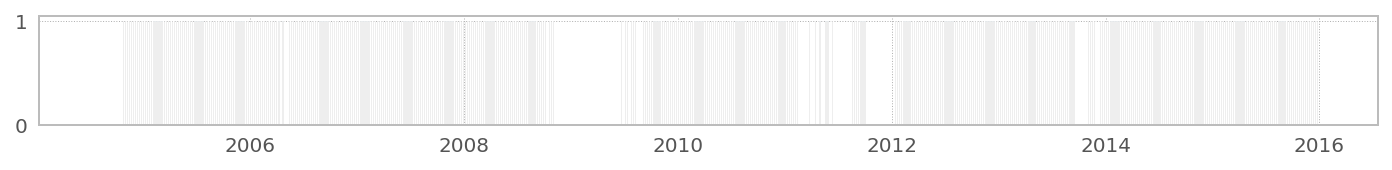

In [36]:
x = train[train["idx"]==2585893]
plt.figure(figsize=(12,1))
plt.bar(x=x["date"], height=x["target"]);

Based on Durbin-Watson we cannot reject serial correlation:

In [37]:
target = train[train["idx"]==2585893]["target"]
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.stattools import durbin_watson as dw
lr = OLS(target, np.ones(len(target))).fit()
dw(lr.resid)

0.4169320932602879

# Filter with 3Y history at least

In [38]:
train.drop("count",axis=1, inplace=True)
data = train[train["cnt"]>=115].sort_values(["date","idx"])

We're dropping about 50% of data:

In [39]:
data["idx"].nunique()/train["idx"].nunique()

0.5200618875709129

In [40]:
log_loss(data["target"],np.ones_like(data["target"])/2)

0.6931471805599464

# Target Mean Encoding

In [41]:
def enc(arr, period, shift=156):
    return arr[-shift - period : -shift].mean()

for period in tqdm([4,12,24,52]):
    name = "tme"+ str(period)
    data[name] = (
        data.
        groupby("idx").
        expanding().
        agg({"target": lambda arr: enc(arr, period)}).
        fillna(0).
        values
    )

print(data.shape)
data.columns

  0%|          | 0/4 [00:00<?, ?it/s]

(1364463, 40)


Index(['date', 'idx', 'f__buytransactions_1m', 'f__selltransactions_1m',
       'f__buyshares_1m', 'f__sellshares_1m', 'f__buysharespctsharesout_1m',
       'f__sellsharespctsharesout_1m', 'f__uniquebuyers_1m',
       'f__uniquesellers_1m', 'f__buytransactions_3m',
       'f__selltransactions_3m', 'f__buyshares_3m', 'f__sellshares_3m',
       'f__buysharespctsharesout_3m', 'f__sellsharespctsharesout_3m',
       'f__uniquebuyers_3m', 'f__uniquesellers_3m', 'f__buytransactions_6m',
       'f__selltransactions_6m', 'f__buyshares_6m', 'f__sellshares_6m',
       'f__buysharespctsharesout_6m', 'f__sellsharespctsharesout_6m',
       'f__uniquebuyers_6m', 'f__uniquesellers_6m', 'f__buytransactions_12m',
       'f__selltransactions_12m', 'f__buyshares_12m', 'f__sellshares_12m',
       'f__buysharespctsharesout_12m', 'f__sellsharespctsharesout_12m',
       'f__uniquebuyers_12m', 'f__uniquesellers_12m', 'target', 'cnt', 'tme4',
       'tme12', 'tme24', 'tme52'],
      dtype='object')

# Feature Enginneering

In [42]:
class RowTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    @staticmethod
    def transform(X, y=None):
        X_ = X.copy()
        X_["year"] = X_["date"].dt.year.astype("int32")
        X_["month"] = X_["date"].dt.month.astype("int32")
        X_["quarter"] = X_["date"].dt.quarter.astype("int32")
        X_["week"] = X_["date"].dt.isocalendar().week.astype("int32")
        X_["day"] = X_["date"].dt.dayofyear.astype("int32")
        X_.drop("date", axis=1, inplace=True)
        X_["btrs_strs_1m"] = X_["f__buytransactions_1m"] - X_["f__selltransactions_1m"]
        X_["btrs_strs_3m"] = X_["f__buytransactions_3m"] - X_["f__selltransactions_3m"]
        X_["btrs_strs_6m"] = X_["f__buytransactions_6m"] - X_["f__selltransactions_6m"]
        X_["btrs_strs_12m"] = X_["f__buytransactions_12m"] - X_["f__selltransactions_12m"]
        X_["bshrs_sshrs_1m"] = X_["f__buyshares_1m"] - X_["f__sellshares_1m"]
        X_["bshrs_sshrs_3m"] = X_["f__buyshares_3m"] - X_["f__sellshares_3m"]
        X_["bshrs_sshrs_6m"] = X_["f__buyshares_6m"] - X_["f__sellshares_6m"]
        X_["bshrs_sshrs_12m"] = X_["f__buyshares_12m"] - X_["f__sellshares_12m"]
        X_["unqb_unqs_1m"] = X_["f__uniquebuyers_1m"] - X_["f__uniquesellers_1m"]
        X_["unqb_unqs_3m"] = X_["f__uniquebuyers_3m"] - X_["f__uniquesellers_3m"]
        X_["unqb_unqs_6m"] = X_["f__uniquebuyers_6m"] - X_["f__uniquesellers_6m"]
        X_["unqb_unqs_12m"] = X_["f__uniquebuyers_12m"] - X_["f__uniquesellers_12m"]
        X_["bpct_spct_1m"] = (
                X_["f__buysharespctsharesout_1m"] + X_["f__sellsharespctsharesout_1m"]
        )
        X_["bpct_spct_3m"] = (
                X_["f__buysharespctsharesout_3m"] + X_["f__sellsharespctsharesout_3m"]
        )
        X_["bpct_spct_6m"] = (
                X_["f__buysharespctsharesout_6m"] + X_["f__sellsharespctsharesout_6m"]
        )
        X_["bpct_spct_12m"] = (
                X_["f__buysharespctsharesout_12m"] + X_["f__sellsharespctsharesout_12m"]
        )
        X_['btrs1m_btrs3m'] = X_["f__buytransactions_1m"] - X_["f__buytransactions_3m"]
        X_['btrs1m_btrs6m'] = X_["f__buytransactions_1m"] - X_["f__buytransactions_6m"]
        X_['btrs1m_btrs12m'] = X_["f__buytransactions_1m"] - X_["f__buytransactions_12m"]
        X_['strs1m_strs3m'] = X_["f__selltransactions_1m"] - X_["f__selltransactions_3m"]
        X_['strs1m_strs6m'] = X_["f__selltransactions_1m"] - X_["f__selltransactions_6m"]
        X_['strs1m_strs12m'] = X_["f__selltransactions_1m"] - X_["f__selltransactions_12m"]
        X_['bsrs1m_bshrs3m'] = X_["f__buyshares_1m"] - X_["f__buyshares_3m"]
        X_['bsrs1m_bshrs6m'] = X_["f__buyshares_1m"] - X_["f__buyshares_6m"]
        X_['bsrs1m_bshrs12m'] = X_["f__buyshares_1m"] - X_["f__buyshares_12m"]
        X_['sshrs1m_sshrs3m'] = X_["f__sellshares_1m"] - X_["f__sellshares_3m"]
        X_['sshrs1m_sshrs6m'] = X_["f__sellshares_1m"] - X_["f__sellshares_6m"]
        X_['sshrs1m_sshrs12m'] = X_["f__sellshares_1m"] - X_["f__sellshares_12m"]
        X_['unqb1m_unqb3m'] = X_['f__uniquebuyers_1m'] - X_['f__uniquebuyers_3m']
        X_['unqb1m_unqb6m'] = X_['f__uniquebuyers_1m'] - X_['f__uniquebuyers_6m']
        X_['unqb1m_unqb12m'] = X_['f__uniquebuyers_1m'] - X_['f__uniquebuyers_12m']
        X_['unqs1m_unqs3m'] = X_["f__uniquesellers_1m"] - X_["f__uniquesellers_3m"]
        X_['unqs1m_unqs6m'] = X_["f__uniquesellers_1m"] - X_["f__uniquesellers_6m"]
        X_['unqs1m_unqs12m'] = X_["f__uniquesellers_1m"] - X_["f__uniquesellers_12m"]
        X_["bpct1m_bpct3m"] = X_["f__buysharespctsharesout_1m"] - X_["f__buysharespctsharesout_3m"]
        X_["bpct1m_bpct6m"] = X_["f__buysharespctsharesout_1m"] - X_["f__buysharespctsharesout_6m"]
        X_["bpct1m_bpct12m"] = X_["f__buysharespctsharesout_1m"] - X_["f__buysharespctsharesout_12m"]
        X_["spct1m_spct3m"] = X_["f__sellsharespctsharesout_1m"] - X_["f__sellsharespctsharesout_3m"]
        X_["spct1m_spct6m"] = X_["f__sellsharespctsharesout_1m"] - X_["f__sellsharespctsharesout_6m"]
        X_["spct1m_spct12m"] = X_["f__sellsharespctsharesout_1m"] - X_["f__sellsharespctsharesout_12m"]
        return X_
    
class ClusterTransformer(BaseEstimator, TransformerMixin):
    '''
    Adds cluster label via fit/transform
    On train:
        fit an transform (concat label column to the original)
    On test:
        transform only
    Args:
        n_clusters
        log: if log transformation should be applied
        col_pair: the columns pair list on which to cluster
        none_cluster: cluster label to assign if there is no counterpart in train
    '''

    def __init__(self, *, n_clusters=10, log=True, col_pair=None, none_cluster=99):
        self.n_clusters = n_clusters
        self.log = log
        self.col_pair = col_pair
        self.none_cluster = none_cluster
        self.km = None
        self.labels = None

    @staticmethod
    def log_trans(df):
        """
        Accepts a 3 column df
        Returns a log-transfomed df of means of columns
        Dimensions are reduced to (num_companies × 2)
        """
        df_ = df.copy()
        return (
                df_.
                groupby("idx").
                mean().
                fillna(0).
                apply(lambda x: np.log(x + 1e-6) if all(x >= 0) else -np.log(-x + 1e-6))
        )

    def fit(self, X, y=None):
        km = KMeans(n_clusters=self.n_clusters, random_state=42)
        sample = X[["idx", *self.col_pair]].copy()
        try:
            log_sample = self.log_trans(sample)
            self.km = km.fit(log_sample)
            self.labels = dict(zip(log_sample.index, self.km.labels_))
        except:
            print("Failed to log-transform pair:", self.col_pair)
            self.labels = dict(zip(log_sample.index, 99))
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        col_name = "cl_" + "_".join(self.col_pair)
        if self.none_cluster is not None:
            X_[col_name] = X_["idx"].map(lambda x: self.labels.get(x, self.none_cluster))
        else:
            try:
                log_sample = self.log_trans(X_[["idx",*self.col_pair]])
                labels = self.km.predict(log_sample)
                labels = dict(zip(log_sample.index, labels))
                X_[col_name] = X_["idx"].map(labels)
            except:
                X_[col_name] = 99
        return X_

# Transformation pipeline

In [43]:
col_list = ['f__buytransactions_1m', 'f__selltransactions_1m',
            'f__buyshares_1m', 'f__sellshares_1m', 
            'f__buysharespctsharesout_1m', 'f__sellsharespctsharesout_1m', 
            'f__uniquebuyers_1m', 'f__uniquesellers_1m',
            'f__buytransactions_3m', 'f__selltransactions_3m', 
            'f__buyshares_3m', 'f__sellshares_3m',
            'f__buysharespctsharesout_3m', 'f__sellsharespctsharesout_3m',
            'f__uniquebuyers_3m', 'f__uniquesellers_3m', 
            'f__buytransactions_6m', 'f__selltransactions_6m', 
            'f__buyshares_6m', 'f__sellshares_6m',
            'f__buysharespctsharesout_6m', 'f__sellsharespctsharesout_6m',
            'f__uniquebuyers_6m', 'f__uniquesellers_6m', 
            'f__buytransactions_12m','f__selltransactions_12m', 
            'f__buyshares_12m', 'f__sellshares_12m',
            'f__buysharespctsharesout_12m', 'f__sellsharespctsharesout_12m',
            'f__uniquebuyers_12m', 'f__uniquesellers_12m']

col_pairs = comb(col_list, 2)

cluster_transformers = [
    ("cl_" + "_".join(pair).replace("__", "_"), ClusterTransformer(col_pair=pair))
    for pair in col_pairs
]

ppl = Pipeline([
    *cluster_transformers, 
    ("row_transformer", RowTransformer())
])

# Train/test split

In [44]:
train_mask = data.date.dt.year <= 2010
test_mask  = (2010 < data.date.dt.year) & (data.date.dt.year < 2014)

X_train_ = data[train_mask].drop("target", axis=1)
y_train  = data[train_mask]["target"]
X_test_  = data[test_mask].drop("target", axis=1)
y_test   = data[test_mask]["target"]

X_train = ppl.fit_transform(X_train_)
X_test  = ppl.transform(X_test_)

print(X_train.shape, X_test.shape)
X_train.columns

(638481, 579) (437033, 579)


Index(['idx', 'f__buytransactions_1m', 'f__selltransactions_1m',
       'f__buyshares_1m', 'f__sellshares_1m', 'f__buysharespctsharesout_1m',
       'f__sellsharespctsharesout_1m', 'f__uniquebuyers_1m',
       'f__uniquesellers_1m', 'f__buytransactions_3m',
       ...
       'unqb1m_unqb12m', 'unqs1m_unqs3m', 'unqs1m_unqs6m', 'unqs1m_unqs12m',
       'bpct1m_bpct3m', 'bpct1m_bpct6m', 'bpct1m_bpct12m', 'spct1m_spct3m',
       'spct1m_spct6m', 'spct1m_spct12m'],
      dtype='object', length=579)

In [45]:
train_ind = list(range(len(X_train)))
test_ind  = list(range(len(X_train),len(X_train)+len(X_test)))
cv = [(train_ind,test_ind)]

# Grid Search

In [46]:
param_grid = {
    "max_depth": [5, 6, 7],
    "num_leaves": [20, 32, 40],
    "min_data_in_leaf": [128, 150, 200],
    "colsample_bytree": [.75, 0.8,.85],
    "learning_rate": [.05, 0.1, .15],
    "subsample": [.6,.7,.8]
}

lgb = LGBMClassifier(
    n_estimators=1000, 
    objective="binary", 
    device="gpu", 
    random_state=42
)

lgb_grid = GridSearchCV(
    lgb, param_grid=param_grid, cv=cv, refit=False, scoring="neg_log_loss"
)

hist = lgb_grid.fit(
    X=pd.concat([X_train, X_test], axis=0),
    y=pd.concat([y_train, y_test]),
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_names=["train","test"],
    early_stopping_rounds=100,
    verbose=50
)

[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.649399	test's binary_logloss: 0.686531
[100]	train's binary_logloss: 0.634525	test's binary_logloss: 0.689234
[150]	train's binary_logloss: 0.623331	test's binary_logloss: 0.692961
Early stopping, best iteration is:
[56]	train's binary_logloss: 0.647111	test's binary_logloss: 0.685791
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.649399	test's binary_logloss: 0.686531
[100]	train's binary_logloss: 0.634525	test's binary_logloss: 0.689232
[150]	train's binary_logloss: 0.623331	test's binary_logloss: 0.692958
Early stopping, best iteration is:
[56]	train's binary_logloss: 0.647111	test's binary_logloss: 0.6

Early stopping, best iteration is:
[68]	train's binary_logloss: 0.634844	test's binary_logloss: 0.686233
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.64242	test's binary_logloss: 0.686896
[100]	train's binary_logloss: 0.624254	test's binary_logloss: 0.688212
[150]	train's binary_logloss: 0.611793	test's binary_logloss: 0.68969
Early stopping, best iteration is:
[68]	train's binary_logloss: 0.634844	test's binary_logloss: 0.68622
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.649308	test's binary_logloss: 0.685403
[100]	train's binary_logloss: 0.634297	test's binary_logloss: 0.689499
Early stopping, best iteration is:
[47]	train's binary_logloss: 0.65

Early stopping, best iteration is:
[15]	train's binary_logloss: 0.662769	test's binary_logloss: 0.686103
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.633143	test's binary_logloss: 0.687692
[100]	train's binary_logloss: 0.611222	test's binary_logloss: 0.689926
Early stopping, best iteration is:
[15]	train's binary_logloss: 0.662769	test's binary_logloss: 0.686103
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.648638	test's binary_logloss: 0.685307
[100]	train's binary_logloss: 0.632487	test's binary_logloss: 0.688826
Early stopping, best iteration is:
[48]	train's binary_logloss: 0.649527	test's binary_logloss: 0.685049
[LightGBM] [Warning] min_data_i

Early stopping, best iteration is:
[35]	train's binary_logloss: 0.643585	test's binary_logloss: 0.685717
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.648337	test's binary_logloss: 0.68696
[100]	train's binary_logloss: 0.632232	test's binary_logloss: 0.687072
Early stopping, best iteration is:
[43]	train's binary_logloss: 0.651262	test's binary_logloss: 0.686203
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.648337	test's binary_logloss: 0.68696
[100]	train's binary_logloss: 0.632232	test's binary_logloss: 0.687063
Early stopping, best iteration is:
[43]	train's binary_logloss: 0.651262	test's binary_logloss: 0.686203
[LightGBM] [Warning] min_data_in_

Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.648337	test's binary_logloss: 0.68696
[100]	train's binary_logloss: 0.631998	test's binary_logloss: 0.687414
Early stopping, best iteration is:
[43]	train's binary_logloss: 0.651262	test's binary_logloss: 0.686203
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.648337	test's binary_logloss: 0.68696
[100]	train's binary_logloss: 0.631998	test's binary_logloss: 0.687414
Early stopping, best iteration is:
[43]	train's binary_logloss: 0.651262	test's binary_logloss: 0.686203
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.648337	test's binary_logloss: 0.68696
[100]	t

[50]	train's binary_logloss: 0.634851	test's binary_logloss: 0.689452
[100]	train's binary_logloss: 0.614974	test's binary_logloss: 0.694334
Early stopping, best iteration is:
[20]	train's binary_logloss: 0.653986	test's binary_logloss: 0.686927
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.634851	test's binary_logloss: 0.68948
[100]	train's binary_logloss: 0.614974	test's binary_logloss: 0.694486
Early stopping, best iteration is:
[20]	train's binary_logloss: 0.653986	test's binary_logloss: 0.686927
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.625629	test's binary_logloss: 0.689029
[100]	train's binary_logloss: 0.600744	test's binary_logloss: 0.697

[100]	train's binary_logloss: 0.611737	test's binary_logloss: 0.699369
Early stopping, best iteration is:
[22]	train's binary_logloss: 0.650998	test's binary_logloss: 0.684906
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.618855	test's binary_logloss: 0.699491
[100]	train's binary_logloss: 0.591802	test's binary_logloss: 0.713372
Early stopping, best iteration is:
[8]	train's binary_logloss: 0.663632	test's binary_logloss: 0.684207
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.618855	test's binary_logloss: 0.699491
[100]	train's binary_logloss: 0.591183	test's binary_logloss: 0.70825
Early stopping, best iteration is:
[8]	train's binary_logloss: 0.66

Early stopping, best iteration is:
[8]	train's binary_logloss: 0.663632	test's binary_logloss: 0.684207
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.618538	test's binary_logloss: 0.69216
[100]	train's binary_logloss: 0.590955	test's binary_logloss: 0.697298
Early stopping, best iteration is:
[8]	train's binary_logloss: 0.663632	test's binary_logloss: 0.684207
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.618538	test's binary_logloss: 0.69216
[100]	train's binary_logloss: 0.590955	test's binary_logloss: 0.697297
Early stopping, best iteration is:
[8]	train's binary_logloss: 0.663632	test's binary_logloss: 0.684207
[LightGBM] [Warning] min_data_in_lea

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.61656	test's binary_logloss: 0.692618
[100]	train's binary_logloss: 0.588892	test's binary_logloss: 0.69887
Early stopping, best iteration is:
[13]	train's binary_logloss: 0.653738	test's binary_logloss: 0.685255
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.607672	test's binary_logloss: 0.691145
[100]	train's binary_logloss: 0.576141	test's binary_logloss: 0.707515
Early stopping, best iteration is:
[18]	train's binary_logloss: 0.641218	test's binary_logloss: 0.684524
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until

Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.611187	test's binary_logloss: 0.697132
[100]	train's binary_logloss: 0.580166	test's binary_logloss: 0.702212
Early stopping, best iteration is:
[5]	train's binary_logloss: 0.66705	test's binary_logloss: 0.684773
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.611187	test's binary_logloss: 0.697133
[100]	train's binary_logloss: 0.580166	test's binary_logloss: 0.702305
Early stopping, best iteration is:
[5]	train's binary_logloss: 0.66705	test's binary_logloss: 0.684773
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.611187	test's binary_logloss: 0.697139
[100]	tr

[50]	train's binary_logloss: 0.611363	test's binary_logloss: 0.692629
[100]	train's binary_logloss: 0.581691	test's binary_logloss: 0.703196
Early stopping, best iteration is:
[5]	train's binary_logloss: 0.667105	test's binary_logloss: 0.684757
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.611364	test's binary_logloss: 0.692636
[100]	train's binary_logloss: 0.581691	test's binary_logloss: 0.703208
Early stopping, best iteration is:
[5]	train's binary_logloss: 0.667105	test's binary_logloss: 0.684766
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.622301	test's binary_logloss: 0.693146
[100]	train's binary_logloss: 0.596265	test's binary_logloss: 0.6967

[100]	train's binary_logloss: 0.557356	test's binary_logloss: 0.725056
Early stopping, best iteration is:
[8]	train's binary_logloss: 0.652444	test's binary_logloss: 0.683834
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.621328	test's binary_logloss: 0.692659
[100]	train's binary_logloss: 0.594732	test's binary_logloss: 0.697522
Early stopping, best iteration is:
[19]	train's binary_logloss: 0.646256	test's binary_logloss: 0.686183
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.621328	test's binary_logloss: 0.692663
[100]	train's binary_logloss: 0.594732	test's binary_logloss: 0.697522
Early stopping, best iteration is:
[19]	train's binary_logloss: 0.

Early stopping, best iteration is:
[21]	train's binary_logloss: 0.643525	test's binary_logloss: 0.685977
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.621195	test's binary_logloss: 0.689398
[100]	train's binary_logloss: 0.594889	test's binary_logloss: 0.69493
Early stopping, best iteration is:
[21]	train's binary_logloss: 0.643525	test's binary_logloss: 0.685977
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.621195	test's binary_logloss: 0.689403
[100]	train's binary_logloss: 0.594889	test's binary_logloss: 0.69419
Early stopping, best iteration is:
[21]	train's binary_logloss: 0.643525	test's binary_logloss: 0.685977
[LightGBM] [Warning] min_data_in_

[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.649496	test's binary_logloss: 0.687875
[100]	train's binary_logloss: 0.634644	test's binary_logloss: 0.687428
Early stopping, best iteration is:
[42]	train's binary_logloss: 0.652859	test's binary_logloss: 0.686024
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.642762	test's binary_logloss: 0.686488
[100]	train's binary_logloss: 0.625294	test's binary_logloss: 0.688666
Early stopping, best iteration is:
[43]	train's binary_logloss: 0.646483	test's binary_logloss: 0.68584
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training unti

[150]	train's binary_logloss: 0.623478	test's binary_logloss: 0.6899
Early stopping, best iteration is:
[78]	train's binary_logloss: 0.64052	test's binary_logloss: 0.686126
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.642923	test's binary_logloss: 0.686627
[100]	train's binary_logloss: 0.62522	test's binary_logloss: 0.687563
Early stopping, best iteration is:
[44]	train's binary_logloss: 0.646048	test's binary_logloss: 0.68605
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.642923	test's binary_logloss: 0.686628
[100]	train's binary_logloss: 0.62522	test's binary_logloss: 0.687565
Early stopping, best iteration is:
[44]	train's binary_logloss: 0.64604

[100]	train's binary_logloss: 0.618016	test's binary_logloss: 0.687805
Early stopping, best iteration is:
[19]	train's binary_logloss: 0.660586	test's binary_logloss: 0.684697
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.638562	test's binary_logloss: 0.685953
[100]	train's binary_logloss: 0.618016	test's binary_logloss: 0.687809
Early stopping, best iteration is:
[19]	train's binary_logloss: 0.660586	test's binary_logloss: 0.684697
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.638562	test's binary_logloss: 0.685953
[100]	train's binary_logloss: 0.618016	test's binary_logloss: 0.687812
Early stopping, best iteration is:
[19]	train's binary_logloss: 0

Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.637431	test's binary_logloss: 0.685452
[100]	train's binary_logloss: 0.615902	test's binary_logloss: 0.687671
Early stopping, best iteration is:
[43]	train's binary_logloss: 0.641331	test's binary_logloss: 0.684783
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.637431	test's binary_logloss: 0.685452
[100]	train's binary_logloss: 0.615902	test's binary_logloss: 0.687671
Early stopping, best iteration is:
[43]	train's binary_logloss: 0.641331	test's binary_logloss: 0.684783
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.631637	test's binary_logloss: 0.685494
[100

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.637261	test's binary_logloss: 0.684673
[100]	train's binary_logloss: 0.616499	test's binary_logloss: 0.688606
[150]	train's binary_logloss: 0.601724	test's binary_logloss: 0.691132
Early stopping, best iteration is:
[50]	train's binary_logloss: 0.637261	test's binary_logloss: 0.684673
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.631577	test's binary_logloss: 0.687359
[100]	train's binary_logloss: 0.60744	test's binary_logloss: 0.687743
Early stopping, best iteration is:
[19]	train's binary_logloss: 0.657106	test's binary_logloss: 0.685763
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_sample

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.625146	test's binary_logloss: 0.68717
[100]	train's binary_logloss: 0.601115	test's binary_logloss: 0.692569
Early stopping, best iteration is:
[15]	train's binary_logloss: 0.654419	test's binary_logloss: 0.684628
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.625146	test's binary_logloss: 0.687067
[100]	train's binary_logloss: 0.601115	test's binary_logloss: 0.692373
Early stopping, best iteration is:
[16]	train's binary_logloss: 0.652916	test's binary_logloss: 0.684668
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training unti

[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.611692	test's binary_logloss: 0.689566
[100]	train's binary_logloss: 0.580418	test's binary_logloss: 0.696224
Early stopping, best iteration is:
[13]	train's binary_logloss: 0.651217	test's binary_logloss: 0.683611
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.611692	test's binary_logloss: 0.689682
[100]	train's binary_logloss: 0.580418	test's binary_logloss: 0.69646
Early stopping, best iteration is:
[13]	train's binary_logloss: 0.651217	test's binary_logloss: 0.683611
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training unti

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.611791	test's binary_logloss: 0.692809
[100]	train's binary_logloss: 0.582552	test's binary_logloss: 0.697641
Early stopping, best iteration is:
[16]	train's binary_logloss: 0.645684	test's binary_logloss: 0.683646
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.63232	test's binary_logloss: 0.687675
[100]	train's binary_logloss: 0.611049	test's binary_logloss: 0.694189
Early stopping, best iteration is:
[37]	train's binary_logloss: 0.639946	test's binary_logloss: 0.686732
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training unti

Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.632313	test's binary_logloss: 0.687602
[100]	train's binary_logloss: 0.610301	test's binary_logloss: 0.692173
Early stopping, best iteration is:
[37]	train's binary_logloss: 0.639946	test's binary_logloss: 0.686732
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.632313	test's binary_logloss: 0.687602
[100]	train's binary_logloss: 0.610301	test's binary_logloss: 0.692174
Early stopping, best iteration is:
[37]	train's binary_logloss: 0.639946	test's binary_logloss: 0.686732
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.632313	test's binary_logloss: 0.687602
[100

[50]	train's binary_logloss: 0.624519	test's binary_logloss: 0.695403
[100]	train's binary_logloss: 0.599767	test's binary_logloss: 0.70146
Early stopping, best iteration is:
[10]	train's binary_logloss: 0.658584	test's binary_logloss: 0.685592
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.624519	test's binary_logloss: 0.695402
[100]	train's binary_logloss: 0.599767	test's binary_logloss: 0.701104
Early stopping, best iteration is:
[10]	train's binary_logloss: 0.658584	test's binary_logloss: 0.685592
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.610971	test's binary_logloss: 0.69596
[100]	train's binary_logloss: 0.582156	test's binary_logloss: 0.7076

[100]	train's binary_logloss: 0.592796	test's binary_logloss: 0.704628
Early stopping, best iteration is:
[20]	train's binary_logloss: 0.644832	test's binary_logloss: 0.687311
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.603134	test's binary_logloss: 0.713037
[100]	train's binary_logloss: 0.569533	test's binary_logloss: 0.70441
Early stopping, best iteration is:
[6]	train's binary_logloss: 0.66182	test's binary_logloss: 0.684001
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.603134	test's binary_logloss: 0.713048
[100]	train's binary_logloss: 0.569533	test's binary_logloss: 0.704514
Early stopping, best iteration is:
[6]	train's binary_logloss: 0.661

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.604383	test's binary_logloss: 0.717225
[100]	train's binary_logloss: 0.571389	test's binary_logloss: 0.718765
Early stopping, best iteration is:
[6]	train's binary_logloss: 0.66182	test's binary_logloss: 0.684001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.604383	test's binary_logloss: 0.717657
[100]	train's binary_logloss: 0.571389	test's binary_logloss: 0.71914
Early stopping, best iteration is:
[6]	train's binary_logloss: 0.66182	test's binary_logloss: 0.684001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until va

Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.602166	test's binary_logloss: 0.69455
[100]	train's binary_logloss: 0.568348	test's binary_logloss: 0.713789
Early stopping, best iteration is:
[7]	train's binary_logloss: 0.658378	test's binary_logloss: 0.685202
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.592525	test's binary_logloss: 0.694628
[100]	train's binary_logloss: 0.553532	test's binary_logloss: 0.703493
Early stopping, best iteration is:
[6]	train's binary_logloss: 0.658504	test's binary_logloss: 0.685107
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.592525	test's binary_logloss: 0.694608
[100]	t

[50]	train's binary_logloss: 0.642829	test's binary_logloss: 0.684884
[100]	train's binary_logloss: 0.624347	test's binary_logloss: 0.689185
Early stopping, best iteration is:
[35]	train's binary_logloss: 0.651199	test's binary_logloss: 0.684678
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.642829	test's binary_logloss: 0.684836
[100]	train's binary_logloss: 0.624347	test's binary_logloss: 0.689591
Early stopping, best iteration is:
[35]	train's binary_logloss: 0.651199	test's binary_logloss: 0.68459
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.642829	test's binary_logloss: 0.684837
[100]	train's binary_logloss: 0.624347	test's binary_logloss: 0.689

[50]	train's binary_logloss: 0.642855	test's binary_logloss: 0.685617
[100]	train's binary_logloss: 0.624983	test's binary_logloss: 0.687715
Early stopping, best iteration is:
[43]	train's binary_logloss: 0.646673	test's binary_logloss: 0.685098
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.642855	test's binary_logloss: 0.685618
[100]	train's binary_logloss: 0.624983	test's binary_logloss: 0.687693
Early stopping, best iteration is:
[43]	train's binary_logloss: 0.646673	test's binary_logloss: 0.685098
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.64863	test's binary_logloss: 0.685873
[100]	train's binary_logloss: 0.632714	test's binary_logloss: 0.689

[150]	train's binary_logloss: 0.594639	test's binary_logloss: 0.691886
Early stopping, best iteration is:
[72]	train's binary_logloss: 0.62196	test's binary_logloss: 0.685254
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.632731	test's binary_logloss: 0.685945
[100]	train's binary_logloss: 0.610397	test's binary_logloss: 0.686664
[150]	train's binary_logloss: 0.594639	test's binary_logloss: 0.69183
Early stopping, best iteration is:
[72]	train's binary_logloss: 0.62196	test's binary_logloss: 0.685251
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.648495	test's binary_logloss: 0.685979
[100]	train's binary_logloss: 0.632554	test's binary_logloss: 0.6884

[100]	train's binary_logloss: 0.606995	test's binary_logloss: 0.687981
Early stopping, best iteration is:
[16]	train's binary_logloss: 0.660481	test's binary_logloss: 0.685721
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.631224	test's binary_logloss: 0.687147
[100]	train's binary_logloss: 0.606995	test's binary_logloss: 0.687969
Early stopping, best iteration is:
[16]	train's binary_logloss: 0.660481	test's binary_logloss: 0.685721
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.648315	test's binary_logloss: 0.686442
[100]	train's binary_logloss: 0.631887	test's binary_logloss: 0.687494
[150]	train's binary_logloss: 0.61988	test's binary_logloss: 0.69

[100]	train's binary_logloss: 0.60696	test's binary_logloss: 0.688934
Early stopping, best iteration is:
[45]	train's binary_logloss: 0.634676	test's binary_logloss: 0.685657
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.631371	test's binary_logloss: 0.686034
[100]	train's binary_logloss: 0.60696	test's binary_logloss: 0.688931
Early stopping, best iteration is:
[45]	train's binary_logloss: 0.634676	test's binary_logloss: 0.685656
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.634291	test's binary_logloss: 0.689623
[100]	train's binary_logloss: 0.615399	test's binary_logloss: 0.69707
Early stopping, best iteration is:
[24]	train's binary_logloss: 0.65

[100]	train's binary_logloss: 0.600524	test's binary_logloss: 0.693638
Early stopping, best iteration is:
[12]	train's binary_logloss: 0.658639	test's binary_logloss: 0.684235
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.634398	test's binary_logloss: 0.689577
[100]	train's binary_logloss: 0.614147	test's binary_logloss: 0.696842
Early stopping, best iteration is:
[24]	train's binary_logloss: 0.650128	test's binary_logloss: 0.685812
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.634398	test's binary_logloss: 0.689577
[100]	train's binary_logloss: 0.614147	test's binary_logloss: 0.696975
Early stopping, best iteration is:
[24]	train's binary_logloss: 0

[100]	train's binary_logloss: 0.611607	test's binary_logloss: 0.697053
Early stopping, best iteration is:
[31]	train's binary_logloss: 0.643892	test's binary_logloss: 0.686257
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.632533	test's binary_logloss: 0.688039
[100]	train's binary_logloss: 0.611607	test's binary_logloss: 0.697055
Early stopping, best iteration is:
[31]	train's binary_logloss: 0.643892	test's binary_logloss: 0.686257
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.632533	test's binary_logloss: 0.688039
[100]	train's binary_logloss: 0.611607	test's binary_logloss: 0.697054
Early stopping, best iteration is:
[31]	train's binary_logloss: 0

[100]	train's binary_logloss: 0.610327	test's binary_logloss: 0.697178
Early stopping, best iteration is:
[17]	train's binary_logloss: 0.65558	test's binary_logloss: 0.68735
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.63182	test's binary_logloss: 0.688404
[100]	train's binary_logloss: 0.610327	test's binary_logloss: 0.697194
Early stopping, best iteration is:
[17]	train's binary_logloss: 0.65558	test's binary_logloss: 0.687356
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.61664	test's binary_logloss: 0.689479
[100]	train's binary_logloss: 0.587273	test's binary_logloss: 0.693734
Early stopping, best iteration is:
[14]	train's binary_logloss: 0.6515

Early stopping, best iteration is:
[17]	train's binary_logloss: 0.65558	test's binary_logloss: 0.68735
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.616474	test's binary_logloss: 0.691182
[100]	train's binary_logloss: 0.588273	test's binary_logloss: 0.703275
Early stopping, best iteration is:
[14]	train's binary_logloss: 0.651551	test's binary_logloss: 0.686506
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.616474	test's binary_logloss: 0.691182
[100]	train's binary_logloss: 0.588273	test's binary_logloss: 0.70327
Early stopping, best iteration is:
[14]	train's binary_logloss: 0.651551	test's binary_logloss: 0.686506
[LightGBM] [Warning] min_data_in_l

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.611947	test's binary_logloss: 0.701636
[100]	train's binary_logloss: 0.581254	test's binary_logloss: 0.708264
Early stopping, best iteration is:
[5]	train's binary_logloss: 0.66704	test's binary_logloss: 0.684907
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.611947	test's binary_logloss: 0.700576
[100]	train's binary_logloss: 0.581254	test's binary_logloss: 0.7073
Early stopping, best iteration is:
[5]	train's binary_logloss: 0.66704	test's binary_logloss: 0.684907
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until val

Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.604799	test's binary_logloss: 0.697473
[100]	train's binary_logloss: 0.570822	test's binary_logloss: 0.705337
Early stopping, best iteration is:
[6]	train's binary_logloss: 0.661569	test's binary_logloss: 0.684443
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.59435	test's binary_logloss: 0.698167
[100]	train's binary_logloss: 0.556593	test's binary_logloss: 0.706362
Early stopping, best iteration is:
[6]	train's binary_logloss: 0.659355	test's binary_logloss: 0.68491
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.59435	test's binary_logloss: 0.698169
[100]	tra

[50]	train's binary_logloss: 0.594661	test's binary_logloss: 0.692881
[100]	train's binary_logloss: 0.557525	test's binary_logloss: 0.706362
Early stopping, best iteration is:
[6]	train's binary_logloss: 0.659346	test's binary_logloss: 0.685298
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.594661	test's binary_logloss: 0.692926
[100]	train's binary_logloss: 0.557525	test's binary_logloss: 0.706443
Early stopping, best iteration is:
[6]	train's binary_logloss: 0.659346	test's binary_logloss: 0.685298
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.594661	test's binary_logloss: 0.69289
[100]	train's binary_logloss: 0.557525	test's binary_logloss: 0.70660

[100]	train's binary_logloss: 0.552814	test's binary_logloss: 0.717066
Early stopping, best iteration is:
[5]	train's binary_logloss: 0.661648	test's binary_logloss: 0.685016
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.590411	test's binary_logloss: 0.705614
[100]	train's binary_logloss: 0.552814	test's binary_logloss: 0.717079
Early stopping, best iteration is:
[5]	train's binary_logloss: 0.661648	test's binary_logloss: 0.685016
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.620128	test's binary_logloss: 0.704181
[100]	train's binary_logloss: 0.593896	test's binary_logloss: 0.724688
Early stopping, best iteration is:
[12]	train's binary_logloss: 0.6

In [47]:
hist.best_score_

-0.6836106453493749

In [48]:
hist.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_data_in_leaf': 128,
 'num_leaves': 40,
 'subsample': 0.7}

# Shap

In [49]:
pars = hist.best_params_

model = LGBMClassifier(
    n_estimators=1000, objective="binary", device="gpu", random_state=42, **pars
)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_train,y_train),(X_test, y_test)],
    eval_names=("train", "test"),
    early_stopping_rounds=100,
    verbose=10,
    eval_metric="logloss"
)

[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 100 rounds
[10]	train's binary_logloss: 0.656757	test's binary_logloss: 0.684442
[20]	train's binary_logloss: 0.639741	test's binary_logloss: 0.684713
[30]	train's binary_logloss: 0.627941	test's binary_logloss: 0.686762
[40]	train's binary_logloss: 0.619686	test's binary_logloss: 0.688457
[50]	train's binary_logloss: 0.611794	test's binary_logloss: 0.689561
[60]	train's binary_logloss: 0.604479	test's binary_logloss: 0.692279
[70]	train's binary_logloss: 0.597977	test's binary_logloss: 0.692886
[80]	train's binary_logloss: 0.592211	test's binary_logloss: 0.692973
[90]	train's binary_logloss: 0.587376	test's binary_logloss: 0.694534
[100]	train's binary_logloss: 0.581437	test's binary_logloss: 0.695134
[110]	train's binary_logloss: 0.576787	test's binary_logloss: 0.695556
Early stopping, best iteration is:
[13]	tr

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=6, min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=128, min_split_gain=0.0, n_estimators=1000,
               n_jobs=-1, num_leaves=40, objective='binary', random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.7,
               subsample_for_bin=200000, subsample_freq=0)

In [50]:
log_loss(y_test, model.predict_proba(X_test))

0.6836130936946575

In [51]:
from shap import TreeExplainer, summary_plot
exp = TreeExplainer(model, X_train)
sv = np.array(exp.shap_values(X_test, check_additivity=False))

100%|===================| 435415/437033 [04:18<00:00]        

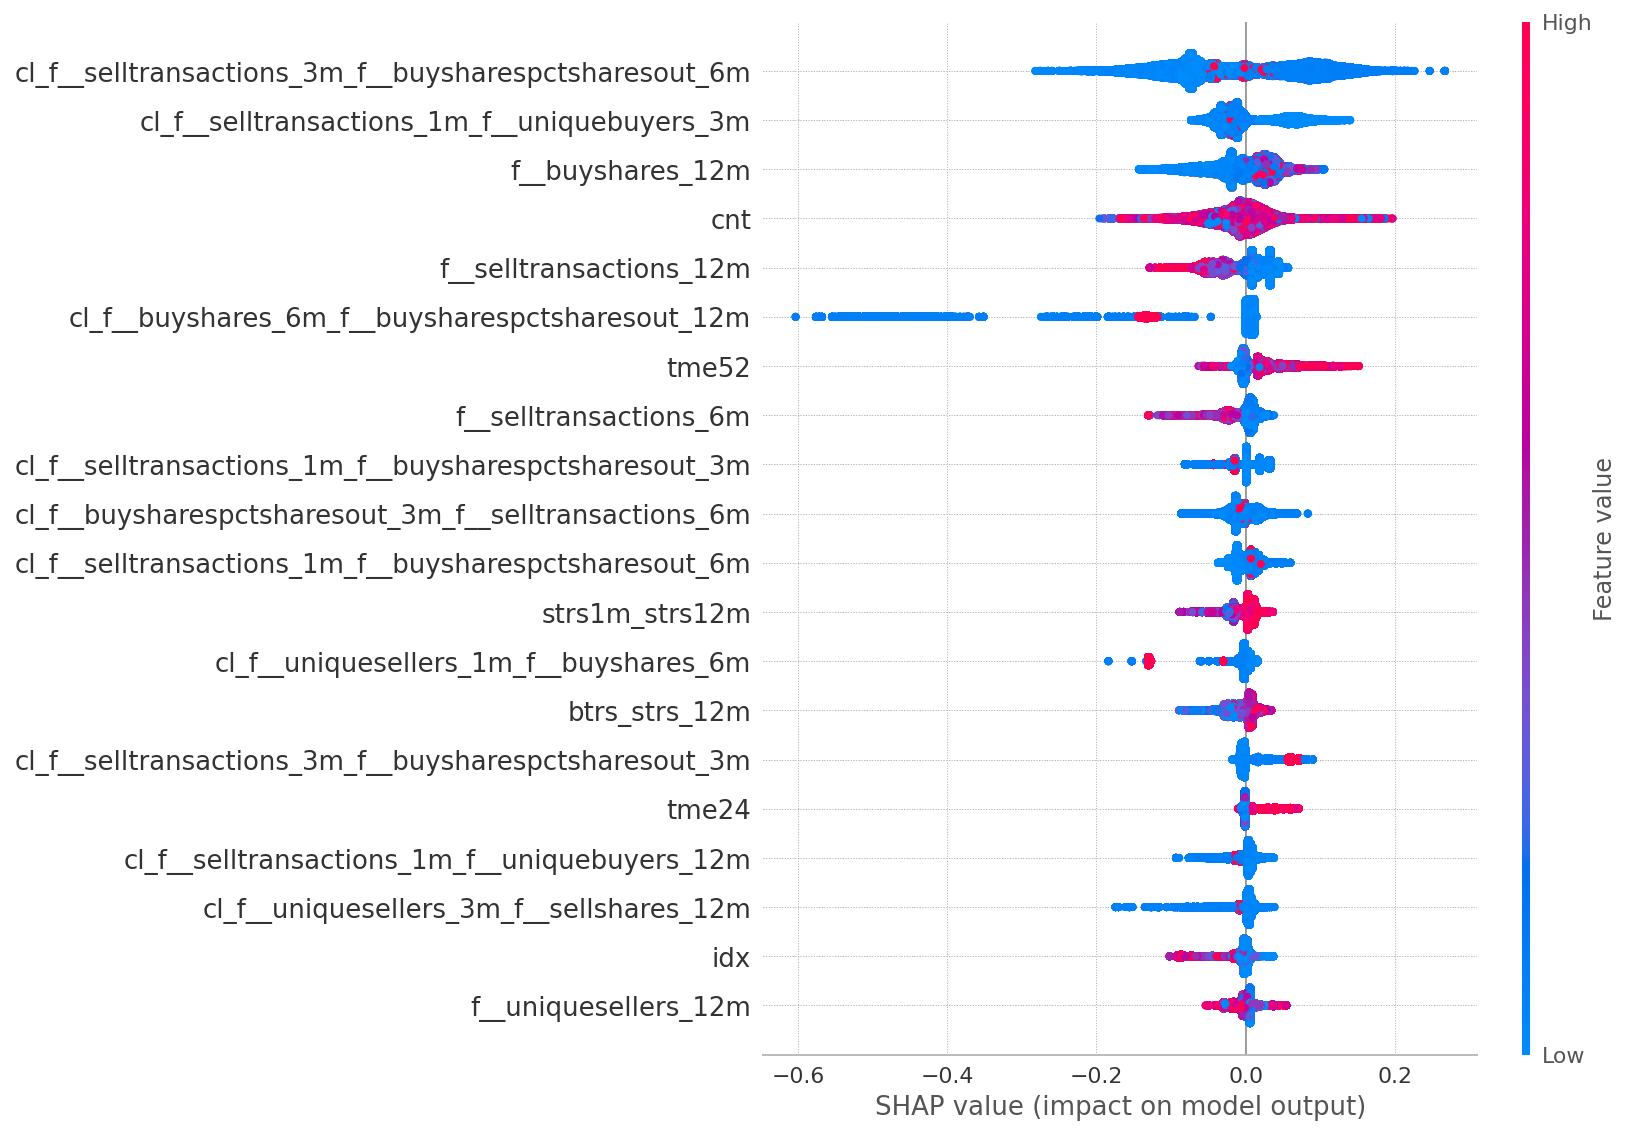

In [52]:
summary_plot(sv, X_test)

In [53]:
sv_cols = X_train.columns[np.abs(sv).mean(0).argsort()[::-1]]

In [54]:
model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=6, min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=128, min_split_gain=0.0, n_estimators=1000,
               n_jobs=-1, num_leaves=40, objective='binary', random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.7,
               subsample_for_bin=200000, subsample_freq=0)

In [55]:
min_ll = 1
ll_shap = []
early_stopping = 100
cnt = 0
for i in tqdm(range(len(sv_cols))):
    model.fit(
        X_train[sv_cols[:i]],
        y_train,
        eval_set=[(X_test[sv_cols[:i]], y_test)],
        early_stopping_rounds=30,
        verbose=-1,
        eval_metric="logloss",
    )
    ll = log_loss(y_test, model.predict_proba(X_test[sv_cols[:i]]))
    ll_shap.append(ll)
    cnt += 1
    if ll < min_ll:
        print("Num cols:", i, "Log loss:", ll)
        min_ll = ll
        cnt=0
        best_num_cols = i
        
    if cnt > early_stopping:
        print("Early stopping occurred at:", i, "step, after", early_stopping)
        break

  0%|          | 0/579 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.694285
Num cols: 0 Log loss: 0.6918513160876241
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.691496
Num cols: 1 Log loss: 0.6914963772619053
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.691311
Num cols: 2 Log loss: 0.691310618675115
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.685746
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.685486
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.684277
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.685792
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until valida

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.687045
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.685704
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.685734
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.685738
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignore

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.685847
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.685295
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.687704
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.68463
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. 

In [57]:
print(" Best mum cols to use:", best_num_cols)
print("Out of sample logloss:", min_ll)
print("Features used:", sv_cols[:best_num_cols])

 Best mum cols to use: 21
Out of sample logloss: 0.6838501271019589
Features used: Index(['cl_f__selltransactions_3m_f__buysharespctsharesout_6m',
       'cl_f__selltransactions_1m_f__uniquebuyers_3m', 'f__buyshares_12m',
       'cnt', 'f__selltransactions_12m',
       'cl_f__buyshares_6m_f__buysharespctsharesout_12m', 'tme52',
       'f__selltransactions_6m',
       'cl_f__selltransactions_1m_f__buysharespctsharesout_3m',
       'cl_f__buysharespctsharesout_3m_f__selltransactions_6m',
       'cl_f__selltransactions_1m_f__buysharespctsharesout_6m',
       'strs1m_strs12m', 'cl_f__uniquesellers_1m_f__buyshares_6m',
       'btrs_strs_12m',
       'cl_f__selltransactions_3m_f__buysharespctsharesout_3m', 'tme24',
       'cl_f__selltransactions_1m_f__uniquebuyers_12m',
       'cl_f__uniquesellers_3m_f__sellshares_12m', 'idx',
       'f__uniquesellers_12m', 'year'],
      dtype='object')
